In [2]:
import random

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series


random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 1 to 198
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Quarter       198 non-null    object 
 1   Consumption   198 non-null    float64
 2   Income        198 non-null    float64
 3   Production    198 non-null    float64
 4   Savings       198 non-null    float64
 5   Unemployment  198 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.8+ KB


In [4]:
df.describe()

,Consumption,Income,Production,Savings,Unemployment
count,198.000000,198.000000,198.000000,198.000000,198.000000
mean,0.742482,0.728169,0.507083,1.392258,0.001010
std,0.637863,0.900393,1.521350,11.966324,0.367318
min,-2.277836,-4.084420,-6.836039,-56.471910,-0.900000
25%,0.417479,0.314376,-0.010780,-4.049088,-0.200000
50%,0.776656,0.760346,0.666085,1.349359,-0.100000
75%,1.097577,1.160228,1.295245,6.341144,0.100000
max,2.319558,4.521869,4.154295,41.607730,1.400000


Utilizaremos modelos baselines como benchmarks para avaliar o desempenho de futuros modelos mais complexos. Esses modelos simples não terão grandes mudanças nos dados, como transformações ou técnicas adicionais. Isso serve para entendermos os resultados da maneira mais simples possível.

In [5]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 1 to 198
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype        
---  ------        --------------  -----        
 0   Quarter       198 non-null    period[Q-DEC]
 1   Consumption   198 non-null    float64      
 2   Income        198 non-null    float64      
 3   Production    198 non-null    float64      
 4   Savings       198 non-null    float64      
 5   Unemployment  198 non-null    float64      
dtypes: float64(5), period[Q-DEC](1)
memory usage: 10.8 KB


In [7]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)

Consumption.head()

# Apply Z-Score Normalization
scaler = StandardScaler()
Consumption["Consumption"] = scaler.fit_transform(Consumption[["Consumption"]])

# Ensure it is a Series and set a compatible index (PeriodIndex)
Consumption.index = pd.PeriodIndex(Consumption.index, freq="Q")
Consumption = Consumption["Consumption"]  # Convert to pandas Series

In [29]:
def fit_and_plot(dataset, strategy, sp=1):
    """
    Function to fit a forecasting strategy and plot the results,
    including the calculation of MAE, RMSE, and MASE.
    """
    train, test = dataset[:-40], dataset[-40:]

    # Fit the forecaster
    forecaster = NaiveForecaster(strategy=strategy, sp=sp)
    forecaster.fit(train)
    
    # Make predictions
    y_pred = forecaster.predict(list(range(1, 41)))

    # Revert predictions and test set to the original scale
    y_pred_original = pd.Series(
        scaler.inverse_transform(y_pred.values.reshape(-1, 1)).flatten(),
        index=y_pred.index
    )
    test_original = pd.Series(
        scaler.inverse_transform(test.values.reshape(-1, 1)).flatten(),
        index=test.index
    )

    # Revert the dataset to the original scale for plotting
    train_original = pd.Series(
        scaler.inverse_transform(train.values.reshape(-1, 1)).flatten(),
        index=train.index
    )

    # Predict intervals
    pred_intervals_95 = forecaster.predict_interval(coverage=0.95)
    pred_intervals_80 = forecaster.predict_interval(coverage=0.80)

    # Calculate error metrics
    mae = mean_absolute_error(test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(test_original, y_pred_original))

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {rmse:.2f}")
    
    # Define method names
    method = {
        "last": "Naive Method",
        "mean": "Mean Method",
        "drift": "Drift Method",
        "seasonal_last": "Seasonal Naive Method",
    }
    
    if sp != 1:
        method["last"] = f"Seasonal Naive Method"

    # Plot results with 95% prediction interval
    fig_1, ax_1 = plot_series(
        train_original,
        test_original,
        y_pred_original,
        labels=["y_train", "y_test", "y_pred"],
        pred_interval=pred_intervals_95,
        title=f"Consumption Prediction - {method[strategy]}",
    )
    ax_1.grid(linestyle="--", zorder=5, linewidth=0.5)
    plt.xlabel("Year")

    # Plot results with 80% prediction interval
    fig_2, ax_2 = plot_series(
        train_original,
        test_original,
        y_pred_original,
        labels=["y_train", "y_test", "y_pred"],
        pred_interval=pred_intervals_80,
        title=f"Consumption Prediction - {method[strategy]}",
    )
    ax_2.grid(linestyle="--", zorder=5, linewidth=0.5)
    plt.xlabel("Year")
    
    plt.show()



### Mean Method

MAE: 0.29
MSE: 0.36


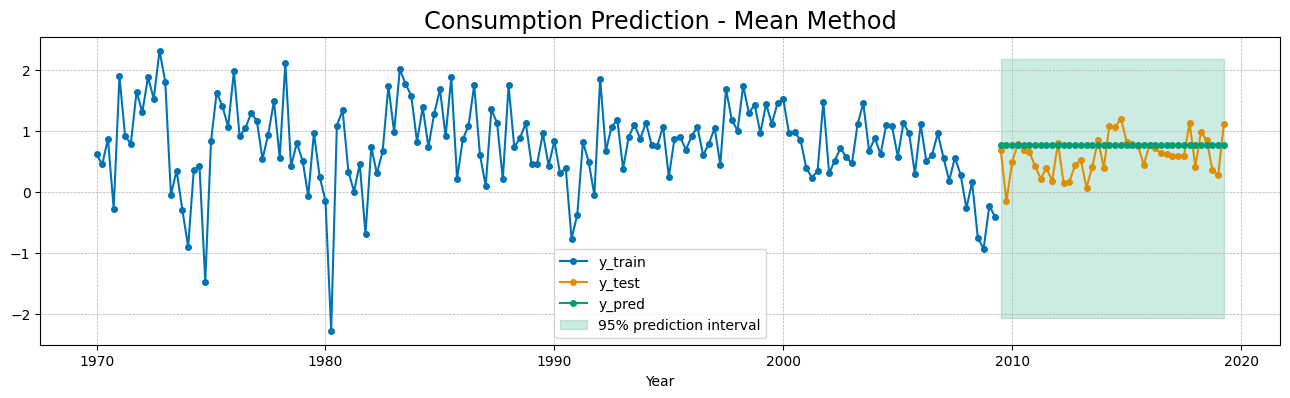

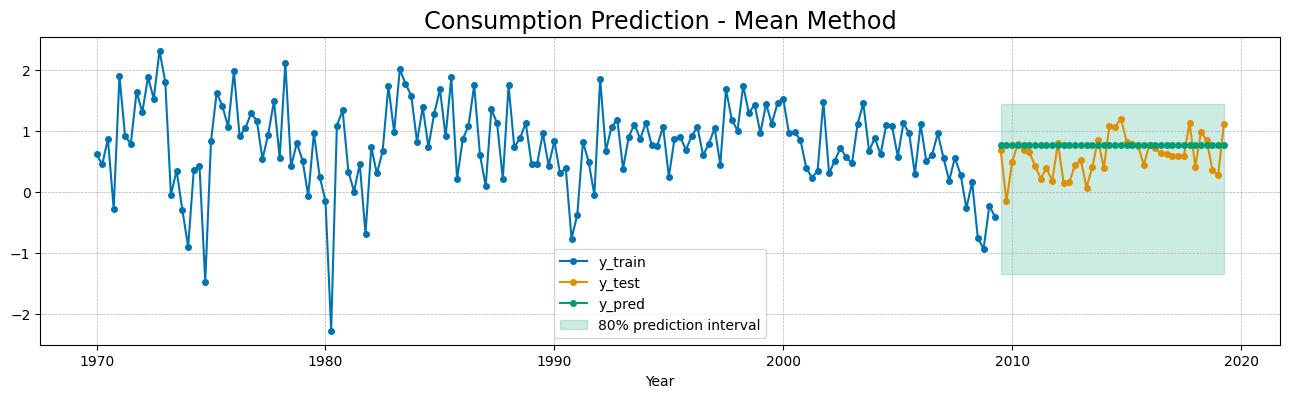

In [30]:
fit_and_plot(Consumption, strategy="mean")

### Naive (or random walk) method

pred_intervals_95=       Consumption           
              0.95           
             lower      upper
2009Q3   -4.272196   0.662529
2009Q4   -5.294212   1.684545
2010Q1   -6.078431   2.468764
2010Q2   -6.739559   3.129892
2010Q3   -7.322025   3.712358
2010Q4   -7.848614   4.238947
2011Q1   -8.332862   4.723195
2011Q2   -8.783590   5.173923
2011Q3   -9.206922   5.597255
2011Q4   -9.607320   5.997653
2012Q1   -9.988151   6.378483
2012Q2  -10.352029   6.742362
2012Q3  -10.701037   7.091370
2012Q4  -11.036860   7.427193
2013Q1  -11.360889   7.751222
2013Q2  -11.674285   8.064618
2013Q3  -11.978031   8.368364
2013Q4  -12.272968   8.663301
2014Q1  -12.559819   8.950152
2014Q2  -12.839216   9.229549
2014Q3  -13.111711   9.502044
2014Q4  -13.377791   9.768124
2015Q1  -13.637890  10.028223
2015Q2  -13.892394  10.282727
2015Q3  -14.141648  10.531981
2015Q4  -14.385965  10.776298
2016Q1  -14.625627  11.015960
2016Q2  -14.860891  11.251224
2016Q3  -15.091989  11.482322
2016Q4  -15.319137  11

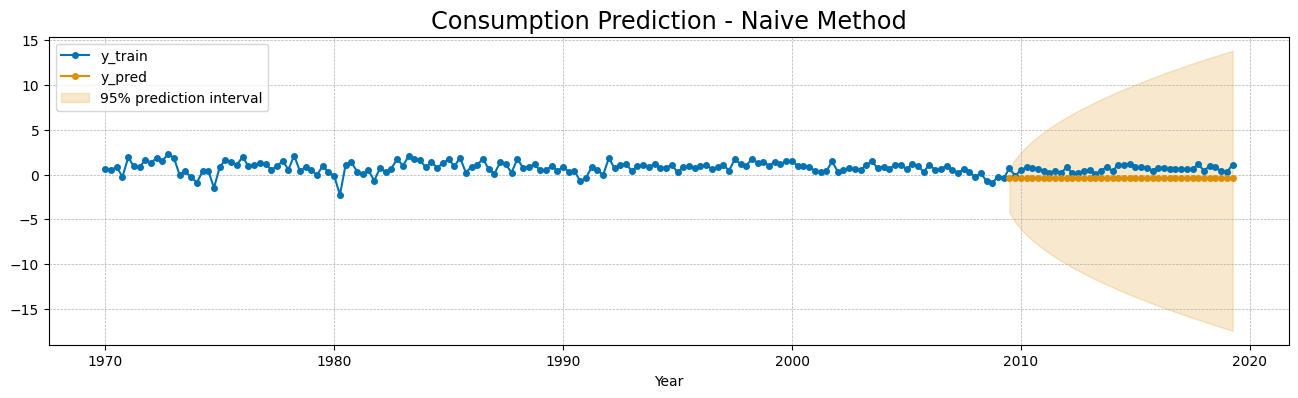

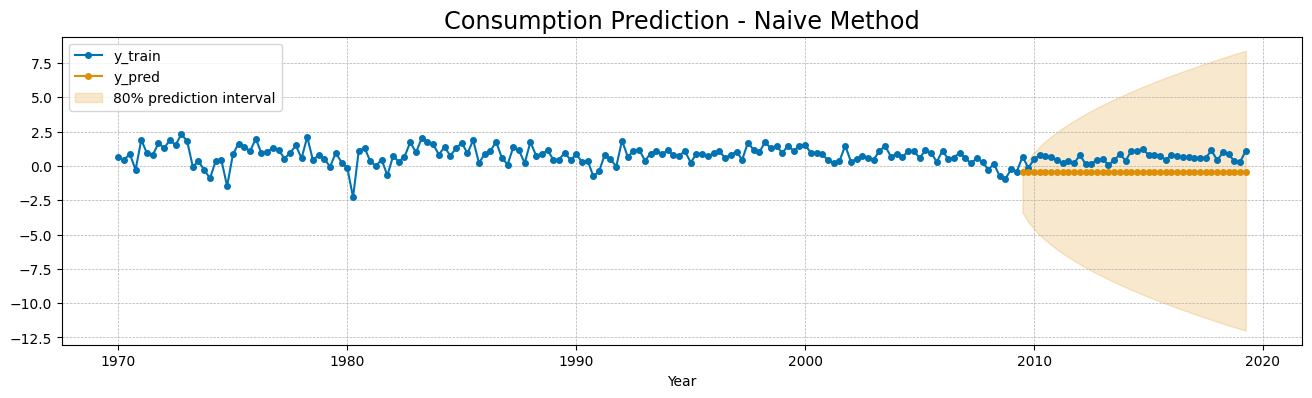

In [10]:
fit_and_plot(Consumption, strategy="last")

### Seasonal Naive method

pred_intervals_95=       Consumption          
              0.95          
             lower     upper
2009Q3   -5.134400  0.437873
2009Q4   -5.422661  0.149612
2010Q1   -4.308493  1.263780
2010Q2   -4.590970  0.981303
2010Q3   -6.288456  1.591928
2010Q4   -6.576716  1.303667
2011Q1   -5.462549  2.417835
2011Q2   -5.745026  2.135358
2011Q3   -7.173994  2.477466
2011Q4   -7.462254  2.189205
2012Q1   -6.348087  3.303373
2012Q2   -6.630563  3.020896
2012Q3   -7.920537  3.224009
2012Q4   -8.208797  2.935748
2013Q1   -7.094630  4.049916
2013Q2   -7.377106  3.767439
2013Q3   -8.578254  3.881727
2013Q4   -8.866515  3.593466
2014Q1   -7.752347  4.707634
2014Q2   -8.034824  4.425157
2014Q3   -9.172876  4.476349
2014Q4   -9.461137  4.188088
2015Q1   -8.346969  5.302256
2015Q2   -8.629446  5.019779
2015Q3   -9.719688  5.023160
2015Q4  -10.007949  4.734900
2016Q1   -8.893781  5.849067
2016Q2   -9.176258  5.566591
2016Q3  -10.228648  5.532120
2016Q4  -10.516908  5.243859
2017Q1   -9.402741  6.358

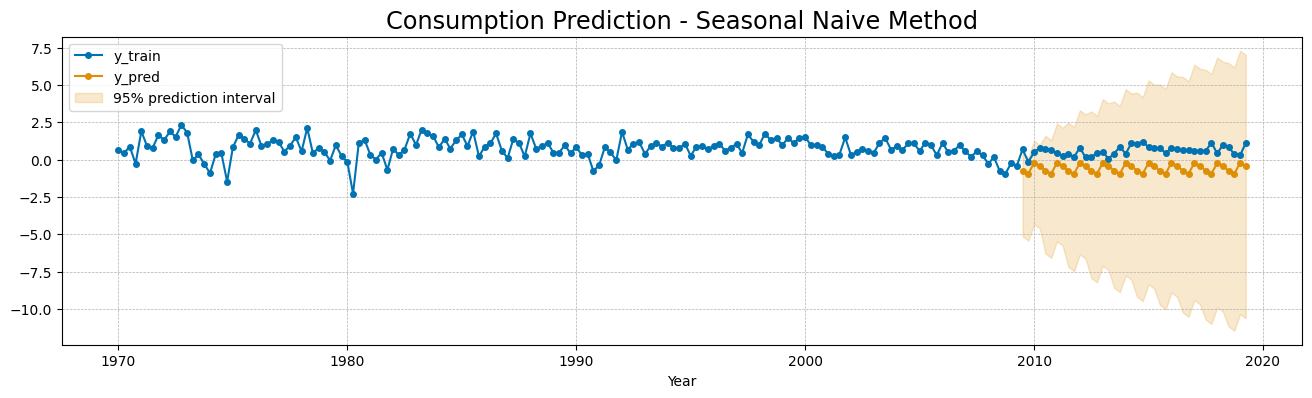

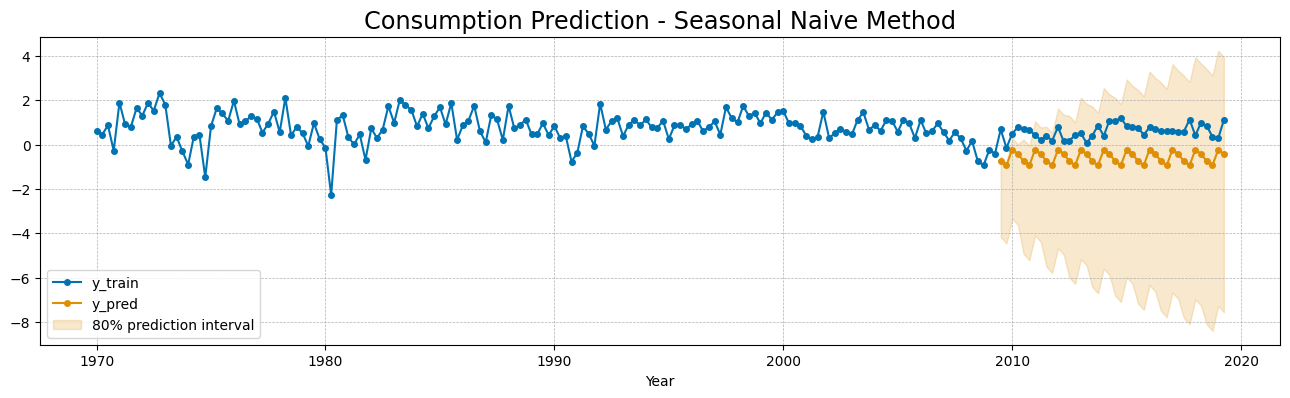

In [11]:
fit_and_plot(Consumption, strategy="last", sp=4)

### Drift method

pred_intervals_95=       Consumption           
              0.95           
             lower      upper
2009Q3   -4.298135   0.667958
2009Q4   -5.347997   1.697309
2010Q1   -6.163497   2.492298
2010Q2   -6.858872   3.167163
2010Q3   -7.478213   3.765994
2010Q4   -8.044050   4.311320
2011Q1   -8.569720   4.816479
2011Q2   -9.063881   5.290130
2011Q3   -9.532528   5.738266
2011Q4   -9.980007   6.165235
2012Q1  -10.409589   6.574306
2012Q2  -10.823805   6.968012
2012Q3  -11.224660   7.348357
2012Q4  -11.613775   7.716961
2013Q1  -11.992479   8.075155
2013Q2  -12.361880   8.424045
2013Q3  -12.722911   8.764565
2013Q4  -13.076366   9.097509
2014Q1  -13.422927   9.423561
2014Q2  -13.763188   9.743311
2014Q3  -14.097664  10.057276
2014Q4  -14.426809  10.365911
2015Q1  -14.751025  10.669616
2015Q2  -15.070667  10.968748
2015Q3  -15.386055  11.263626
2015Q4  -15.697475  11.554535
2016Q1  -16.005184  11.841733
2016Q2  -16.309414  12.125453
2016Q3  -16.610378  12.405906
2016Q4  -16.908267  12

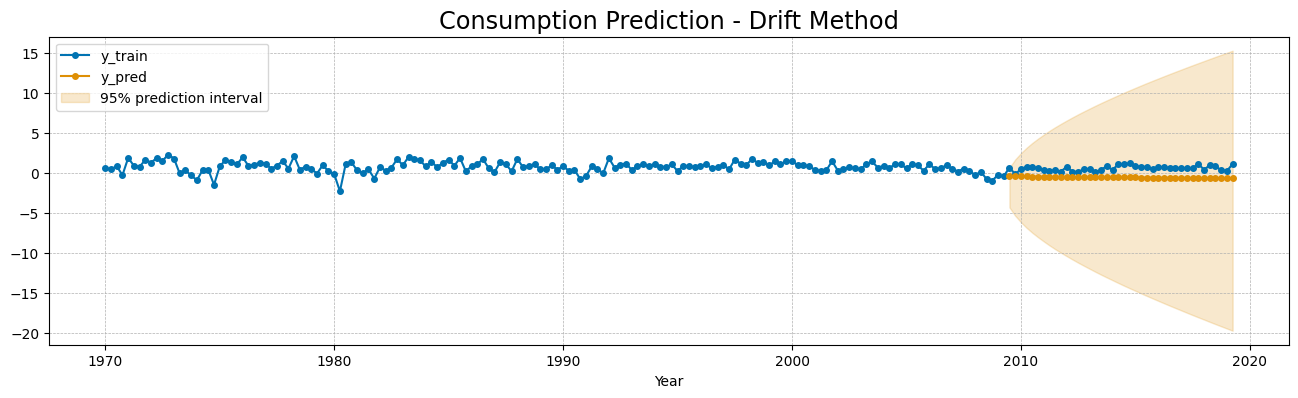

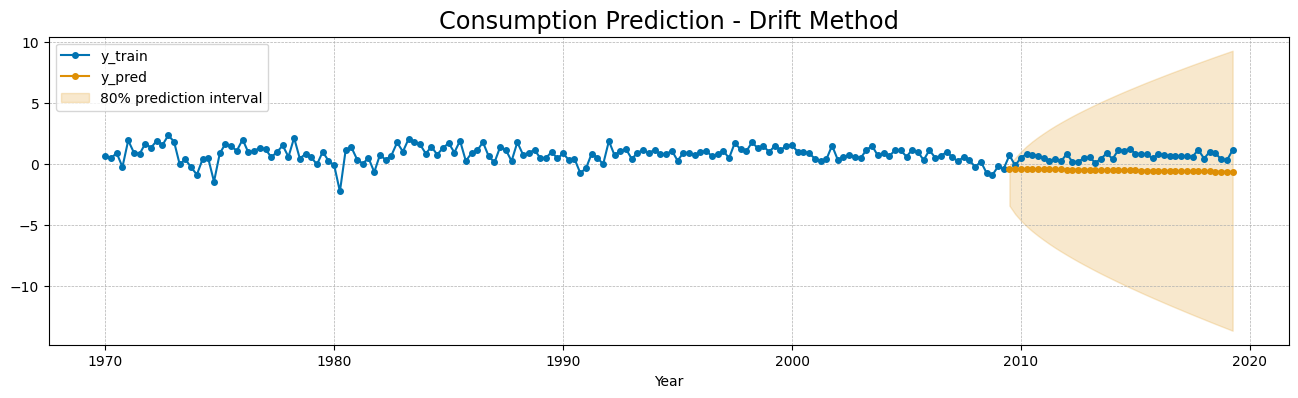

In [12]:
fit_and_plot(Consumption, strategy="drift")
